# Exploratory Data Analysis & Machine Learning Working Code
# _Factors affecting vessel delays at US Army Corps of Engineers-managed locks on US waterways._

## Springboard Data Science Career Track, Capstone 2
***
* Author: Heather A. Passmore
* Data: United States Army Corps of Engineers, Lock Performance Management System
* Capstone Description: [Project Proposal](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/ProjectProposalCap2.md)
* Initial Data Approach: [Data Wrangling Report](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/Data_Wrangling_Report.md)
* Milestone Report: [Predicting Vessel Delays for Corps of Engineers-Lock Performance Management System (LPMS) Data](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/LPMS_Milestone_Report.md)
* Final Report: In Progress
***
## Table of Contents
1. Import Modules & Dataframes
2. Explore Machine Learning Data for 10 Focal Locks

3. Heading 
4. Heading

## 1. Import Modules & Dataframes

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

In [83]:
# Bring ML_LPMS_final dataframe into workspace
# load the pickled ML_LPMS_final DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/ML_LPMS_final.pickle','rb') as f:
    ML = pickle.load(f)

In [84]:
# Check ML contents and data types
ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 15537
Data columns (total 27 columns):
E_R_L                   15538 non-null object
YYMMDD                  15538 non-null datetime64[ns]
delay_cat               15538 non-null int64
LOCKAGE_TYPE            15538 non-null object
VESSEL_FUNCTION_TYPE    15538 non-null object
assist                  15538 non-null int64
year                    15538 non-null int64
day_of_year             15538 non-null int64
day_of_week             15538 non-null int64
month                   15538 non-null int64
hour_of_day             15538 non-null int64
entry_time              15538 non-null float64
exit_time               15538 non-null float64
delay_time              15538 non-null float64
unplan_max_stop         15538 non-null float64
AWND                    15538 non-null float64
PGTM                    15538 non-null float64
PRCP                    15538 non-null float64
SNOW                    15538 non-null float64
SNWD    

## 2. Explore Machine Learning Data for 10 Focal Locks

In [85]:
# Explore data for 10 focal locks
ML.E_R_L.value_counts()

B2_GI_77    1770
B2_FB_41    1763
M3_GI_11    1726
M3_GI_12    1710
B3_MI_27    1660
H2_OH_76    1641
B2_GI_4     1614
M3_GI_14    1571
G3_WS_1     1248
B2_GI_3      835
Name: E_R_L, dtype: int64

In [86]:
ML.LOCKAGE_TYPE.value_counts()

S    9349
O    6070
C      53
K      47
N       9
B       5
V       3
A       1
T       1
Name: LOCKAGE_TYPE, dtype: int64

In [87]:
# Number of observations
ML.shape[0]

15538

In [88]:
# Number of features
ML.shape[1]

27

## 3. Convert all categorical variables remaining to numerical with encoding

In [89]:
# Make a list of categorical columns that need to be encoded (do I need to encode year)
catvar = ['E_R_L', 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE', 'year', 'day_of_year', 'day_of_week', 'month', 
          'hour_of_day']

# Make a list of numerical columns in case of later feature scaling or standarization
numvar = ['entry_time', 'exit_time', 'delay_time', 'unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
          'TMAX', 'TMIN', 'WSF2', 'WSF5', 'WT_count']

# Make a list of binary variables just in case
binvar = ['delay_cat', 'assist', 'WType']

# Also may consider One Hot Coding 'LOCKAGE_TYPE' and 'VESSEL_FUNCTION_TYPE' later

In [90]:
# Use label encoder for categorical variables
lbl_enc = LabelEncoder()
tmp = ML[catvar].apply(lbl_enc.fit_transform)

In [91]:
# Drop the old categorical columns, concatenate ML and tmp
ML.drop(catvar, axis=1, inplace=True)
ML_LPMS = pd.concat([ML, tmp], axis=1)

In [92]:
# Number of observations
ML_LPMS.shape[0]

15538

In [93]:
# Number of features
ML_LPMS.shape[1]

27

In [94]:
ML_LPMS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 15537
Data columns (total 27 columns):
YYMMDD                  15538 non-null datetime64[ns]
delay_cat               15538 non-null int64
assist                  15538 non-null int64
entry_time              15538 non-null float64
exit_time               15538 non-null float64
delay_time              15538 non-null float64
unplan_max_stop         15538 non-null float64
AWND                    15538 non-null float64
PGTM                    15538 non-null float64
PRCP                    15538 non-null float64
SNOW                    15538 non-null float64
SNWD                    15538 non-null float64
TAVG                    15538 non-null float64
TMAX                    15538 non-null float64
TMIN                    15538 non-null float64
WSF2                    15538 non-null float64
WSF5                    15538 non-null float64
WT_count                15538 non-null int64
WType                   15538 non-null objec

In [96]:
# drop 'YYMMDD', 'delay_time', 'entry_time', 'exit_time' column
ML_LPMS.drop(['YYMMDD', 'delay_time', 'entry_time', 'exit_time'], axis=1, inplace=True)
ML_LPMS.shape

(15538, 23)

## 4. Create feature matrix and target vector then split into testing and training

In [97]:
X = ML_LPMS.drop(['delay_cat'], axis=1).values
y = ML_LPMS.delay_cat.values

In [121]:
X.shape

(15538, 22)

In [99]:
# Train Test Split
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 11653
X Testing set sample size: 3885
y Training set sample size: 11653
y Testing set sample size: 3885


In [100]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.542864498412
0.542857142857


## 5. Fit Logistic Regression model

In [101]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

training set score: 0.592380

test set score: 0.592535


In [102]:
# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(X_test)

# print the confusion matrix 
metrics.confusion_matrix(y_test, pred_lgr)

array([[1485,  624],
       [ 959,  817]])

In [103]:
# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(X_test)[:, 1]
y_pred_prob_lgr

array([ 0.53137265,  0.49501801,  0.55437232, ...,  0.42160461,
        0.37806943,  0.31649492])

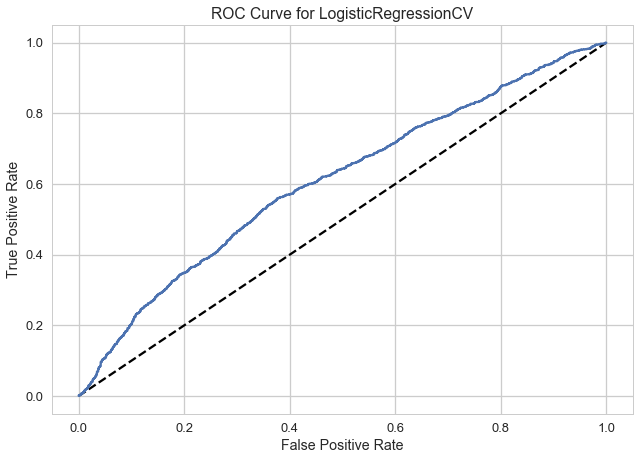

In [104]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

In [105]:
# calculate AUC for LogisticRegressionCV classifier
metrics.roc_auc_score(y_test, y_pred_prob_lgr)

0.60761739691327166

In [106]:
# view paramaters of logistic regression CV
lgr

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

### Consider normalizing variables like 'unplan_max_stop',  and maybe 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'WSF5', 'WT_count'. (Centering & scaling, put it in a pipeline?)
### Consider One Hot Coding 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE' because two levels are more common than the rest in both variables.

## 6. Fit Random Forest Model

In [107]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train, y_train))
print('\n'"test set score: %f" % rf.score(X_test, y_test))

training set score: 0.982236

test set score: 0.654569


In [108]:
# calculated predicted class label per sample: pred_rf
pred_rf = rf.predict(X_test)

# print the confusion matrix 
metrics.confusion_matrix(y_test, pred_rf)

array([[1637,  472],
       [ 870,  906]])

In [109]:
# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_prob_rf

array([ 0.4,  0.4,  0.7, ...,  0.1,  0.5,  0.2])

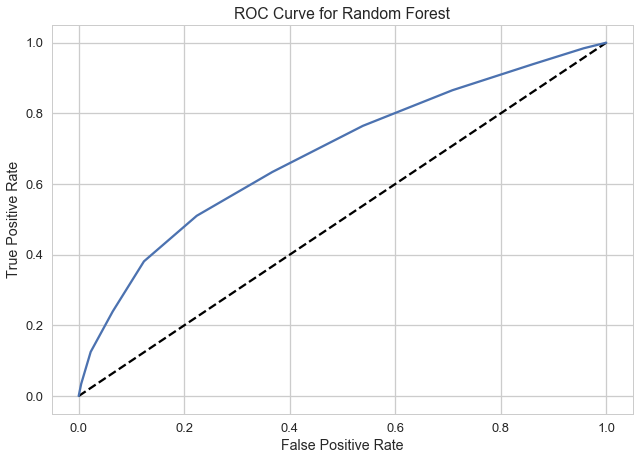

In [110]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [111]:
# calculate AUC for randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_rf)

0.68506846996356241

In [112]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {'max_features': [16, 18, 20],
              'min_samples_leaf': [2, 4, 6],
              'min_samples_split': [7, 8, 10],
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)
         }

In [113]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train) 

In [114]:
# View the best AUC score
print('Best score:', gs_rf.best_score_) 

Best score: 0.723884727108


In [115]:
# Get best parameters
print('Best parameters:', gs_rf.best_params_)

Best parameters: {'max_features': 20, 'min_samples_leaf': 6, 'min_samples_split': 7}


In [116]:
# get array of Random Forest feature importances
rf.feature_importances_

array([ 0.0018643 ,  0.01222167,  0.09044149,  0.00126501,  0.03936674,
        0.00081283,  0.00078427,  0.05346376,  0.08122204,  0.08176559,
        0.0639845 ,  0.06927347,  0.02430602,  0.01280111,  0.07095703,
        0.01896759,  0.02564916,  0.06031834,  0.10070766,  0.05308773,
        0.04403775,  0.09270196])

In [122]:
X_df = ML_LPMS.drop(['delay_cat'], axis=1)
X_df.head()

,assist,unplan_max_stop,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT_count,WType,E_R_L,LOCKAGE_TYPE,VESSEL_FUNCTION_TYPE,year,day_of_year,day_of_week,month,hour_of_day
0,0,0.0,5.14,0.0,0.00,0.0,0.0,0.0,76.0,57.0,...,0,0,8,5,9,2,72,5,2,3
1,0,0.0,9.62,0.0,0.00,0.0,0.0,0.0,89.0,80.0,...,0,0,8,5,9,2,246,4,8,4
2,0,0.0,3.36,0.0,0.27,0.0,0.0,82.0,91.0,78.0,...,1,1,2,6,9,3,192,0,6,8
3,0,0.0,12.53,0.0,0.03,0.0,0.0,0.0,82.0,71.0,...,1,1,9,5,9,4,91,6,3,0
4,0,0.0,11.41,0.0,0.12,0.0,0.0,65.0,72.0,49.0,...,0,0,1,6,9,0,347,5,11,12


In [123]:
# Explore feature importances
#pd.DataFrame(zip(X.columns, np.transpose(rf.best_estimator_.feature_importances_ ))).sort_values(1).tail(10)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [124]:
feature_importances

,importance
day_of_year,0.100708
hour_of_day,0.092702
AWND,0.090441
TMIN,0.081766
TMAX,0.081222
E_R_L,0.070957
WSF5,0.069273
WSF2,0.063985
year,0.060318
TAVG,0.053464


## 7. Try Recusive Feature Elimination

In [132]:
from sklearn.feature_selection import RFE

# QUESTION: should I fit RFE to X, y or to X_train, y_train???
# QUESTION: how many features should I select (n_features_to_select). The default is half, so I entered 10 
# QUESTION: Once I know the 10 featues to keep do I go back and drop those columns from the original dataframe, re-create X and y, and re-run train text split??? Or, do I drop those indices from X-train?

In [134]:
# feature extraction from LogisticRegressionCV
rfe = RFE(lgr, 10, step=1)
fit = rfe.fit(X_train, y_train)
print('Number of Features:', fit.n_features_)
print('Selected Features:',  fit.support_)
print('Feature Ranking:',  fit.ranking_)

Number of Features: 10
Selected Features: [False False False False  True  True  True False False False  True False
 False False  True  True  True  True False  True False  True]
Feature Ranking: [ 9 13  7 12  1  1  1  3  5  6  1  8  2 10  1  1  1  1 11  1  4  1]


In [136]:
# Map the column names to the rankings to see what to keep (1's) and what to drop (ranked above 1)
print('Features sorted by their rank:')
print(sorted(zip(map(lambda x: round(x, 4), fit.ranking_), X_df.columns)))

Features sorted by their rank:
[(1, 'E_R_L'), (1, 'LOCKAGE_TYPE'), (1, 'PRCP'), (1, 'SNOW'), (1, 'SNWD'), (1, 'VESSEL_FUNCTION_TYPE'), (1, 'WSF2'), (1, 'day_of_week'), (1, 'hour_of_day'), (1, 'year'), (2, 'WT_count'), (3, 'TAVG'), (4, 'month'), (5, 'TMAX'), (6, 'TMIN'), (7, 'AWND'), (8, 'WSF5'), (9, 'assist'), (10, 'WType'), (11, 'day_of_year'), (12, 'PGTM'), (13, 'unplan_max_stop')]


In [140]:
# drop 'columns ranked higher than 1 for Logistic Regression
ML_LPMS.drop(['WT_count', 'TAVG', 'month', 'TMAX', 'TMIN', 'AWND', 'WSF5', 'assist', 'WType',
              'day_of_year', 'PGTM', 'unplan_max_stop'], axis=1, inplace=True)
ML_LPMS.shape
# not sure this is the right path. Should I re-create X and y without these columns, re-do training/test and re-run
# model?

(15538, 11)

In [135]:
# feature extraction from RandomForest
rfe_rf = RFE(rf, 10, step=1)
fit_rf = rfe_rf.fit(X_train, y_train)
print('Number of Features:', fit_rf.n_features_)
print('Selected Features:',  fit_rf.support_)
print('Feature Ranking:',  fit_rf.ranking_)

Number of Features: 10
Selected Features: [False False  True False False False False False  True  True  True  True
 False False  True False False  True  True  True False  True]
Feature Ranking: [10  9  1 11  4 13 12  2  1  1  1  1  5  8  1  7  6  1  1  1  3  1]


In [137]:
# Map the column names to the rankings to see what to keep (1's) and what to drop (ranked above 1)
print('Features sorted by their rank:')
print(sorted(zip(map(lambda x: round(x, 4), fit_rf.ranking_), X_df.columns)))

Features sorted by their rank:
[(1, 'AWND'), (1, 'E_R_L'), (1, 'TMAX'), (1, 'TMIN'), (1, 'WSF2'), (1, 'WSF5'), (1, 'day_of_week'), (1, 'day_of_year'), (1, 'hour_of_day'), (1, 'year'), (2, 'TAVG'), (3, 'month'), (4, 'PRCP'), (5, 'WT_count'), (6, 'VESSEL_FUNCTION_TYPE'), (7, 'LOCKAGE_TYPE'), (8, 'WType'), (9, 'unplan_max_stop'), (10, 'assist'), (11, 'PGTM'), (12, 'SNWD'), (13, 'SNOW')]


In [139]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 15537
Data columns (total 22 columns):
assist                  15538 non-null int64
unplan_max_stop         15538 non-null float64
AWND                    15538 non-null float64
PGTM                    15538 non-null float64
PRCP                    15538 non-null float64
SNOW                    15538 non-null float64
SNWD                    15538 non-null float64
TAVG                    15538 non-null float64
TMAX                    15538 non-null float64
TMIN                    15538 non-null float64
WSF2                    15538 non-null float64
WSF5                    15538 non-null float64
WT_count                15538 non-null int64
WType                   15538 non-null object
E_R_L                   15538 non-null int64
LOCKAGE_TYPE            15538 non-null int64
VESSEL_FUNCTION_TYPE    15538 non-null int64
year                    15538 non-null int64
day_of_year             15538 non-null int64
day_of_week  